In [2]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

%matplotlib inline

plt.rcParams.update({'font.size': 20})
root_directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/'

# Load functional data

In [158]:
file = os.path.join(root_directory,'fly_21','func_0','motcorr','motcorr_red.nii')
data = bbb.load_numpy_brain(file)
data.shape


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 12.86 sec


(128, 79, 53, 4370)

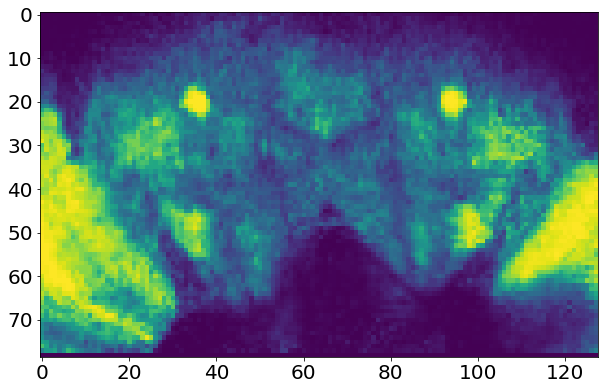

In [159]:
plt.figure(figsize=(10,10))
plt.imshow(data[:,:,20,100].T)

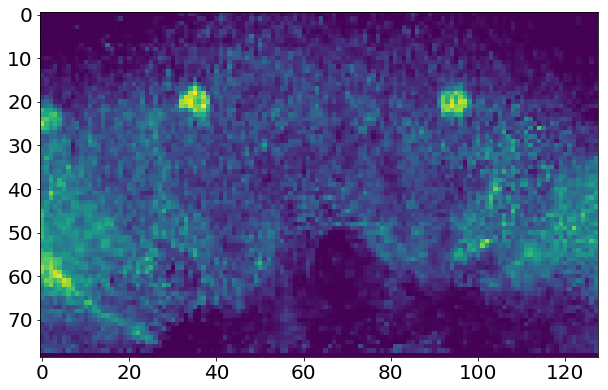

In [157]:
plt.figure(figsize=(10,10))
plt.imshow(data[:,:,20,100].T)

# Load and process fictrac

In [4]:
directory = os.path.join(root_directory,'fly_21','func_0')
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 65.99 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.56 sec


In [23]:
def interp_fictrac(fictrac, fps, resolution, expt_len):
    behavior = 'dRotLabY'
    sigma = 0
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    
    x_original = np.arange(0,expt_len,camera_rate)
    # 20ms resolution
    fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(fictrac[behavior]),25,3)
    #fictrac_smoothed = scipy.ndimage.filters.gaussian_filter(np.asarray(fictrac[behavior]),sigma=sigma)
    #fictrac_smoothed = np.abs(fictrac_smoothed)
    fictrac_interp_temp = interp1d(x_original, fictrac_smoothed, bounds_error = False)
    xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res
    fictrac_interp = fictrac_interp_temp(xnew)

    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    
    return fictrac_interp

resolution = 10 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
fictrac_interp = interp_fictrac(fictrac, fps, resolution, expt_len)
xnew = np.arange(0,expt_len,resolution)

# FUN TIMES

In [24]:
###### CURRENT BEST METHOD ######

B_THRESHOLD = np.std(fictrac_interp)/4
ALIVE_TIME = 1000 # in ms
DEAD_TIME = 1000 # in ms

behavior = 'quiescent'
up_streak = 0
down_streak = 0
BOUTS = []
ALIVE_TIME = int(ALIVE_TIME/resolution)
DEAD_TIME = int(DEAD_TIME/resolution)

for i in range(len(fictrac_interp)):
    # If high behavior, reset down_streak, and add 1 to up_streak
    if fictrac_interp[i] > B_THRESHOLD:
        down_streak = 0
        up_streak += 1
    else:
        up_streak = 0
        down_streak += 1
        
    if behavior == 'quiescent':
        if up_streak >= ALIVE_TIME:
            behavior = 'moving'
            BOUTS.append({'start': i-ALIVE_TIME})
    elif behavior == 'moving':
        if down_streak >= DEAD_TIME:
            behavior = 'quiescent'
            BOUTS[-1]['end'] = i-DEAD_TIME
print('Found {} bouts'.format(len(BOUTS)))

Found 144 bouts


Text(0.5, 0, 'sec')

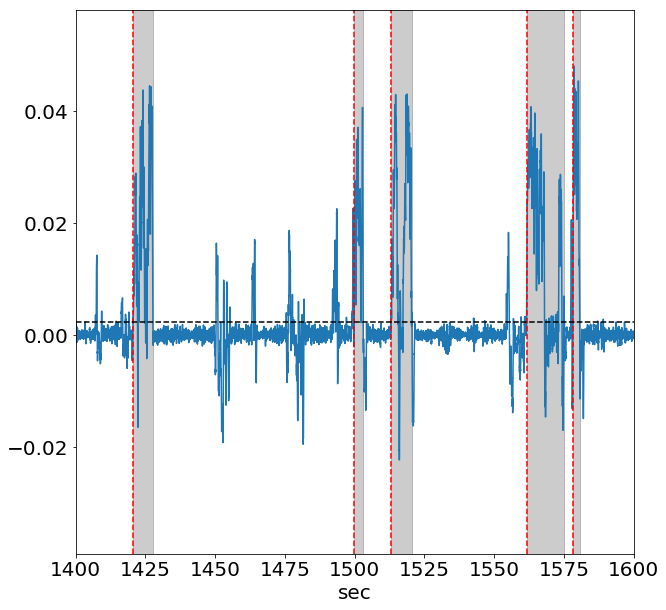

In [25]:
plt.figure(figsize=(10,10))

plt.plot(xnew/1000, fictrac_interp)
#plt.plot(xnew/1000,PB_signal_highres/10)

for bout in BOUTS:
    try:
        plt.axvspan(bout['start']/100, bout['end']/100, alpha=0.2, color='k')
        plt.axvline(bout['start']/100,color='r',linestyle='--')
    except:
        pass
    
plt.axhline(B_THRESHOLD,color='k',linestyle='--')
plt.xlim(1400,1600)
plt.xlabel('sec')
#plt.xlim(808,1000)

In [26]:
# remove bouts that have behavior too close before them
before = 3000 # in ms

before = int(before/10)
bouts=[bout for bout in BOUTS if np.mean(np.abs(fictrac_interp[bout['start']-before:bout['start']])) < .001]
print('Remaining bouts: {}'.format(np.shape(bouts)[0]))

Remaining bouts: 53


Text(0.5, 0, 'ms')

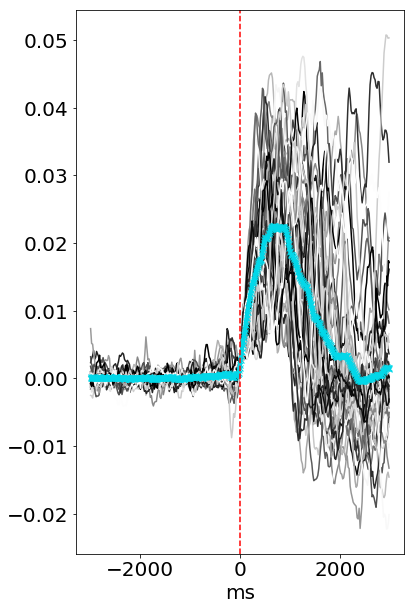

In [49]:
before = 3000 #in ms
after = 3000 # in ms

before = int(before/10) # now everything is in units of 10ms
after = int(after/10)
bins = bbb.create_bins(10,before*10,after*10)[:-1]

plt.figure(figsize=(20,10))
x=bins
plt.subplot(131)
for i,bout in enumerate(bouts):
    y=fictrac_interp[bout['start']-before:bout['start']+after]
    try:
        plt.plot(x,y,color=str(np.random.uniform()))
    except:
        print('{} Failed'.format(i))
all_bouts = [fictrac_interp[bout['start']-before:bout['start']+after] for bout in bouts][1:-1]
all_bouts = np.asarray(all_bouts)
avg_bout = np.mean(all_bouts,axis=0)
plt.plot(x,avg_bout,color='xkcd:aqua blue',linewidth=4,marker='x')
plt.axvline(0,linestyle='--',color='r')
plt.xlabel('ms')
#plt.xlim(-300,300)

# xnew = np.arange(0,expt_len,resolution)
# out = interp1d(timestamps[:,25], PB_R_signal, bounds_error = False)
# PB_R_signal_highres = out(xnew)
# out = interp1d(timestamps[:,25], PB_L_signal, bounds_error = False)
# PB_L_signal_highres = out(xnew)

# bout_triggered_PB_R = [PB_R_signal_highres[bout['start']-before:bout['start']+after] for bout in bouts][1:-1]
# #bout_triggered_PB_R_normalized=bout_triggered_PB_R
# bout_triggered_PB_R_normalized = [(bout-np.mean(bout[:200]))/np.mean(bout[:200]) for bout in bout_triggered_PB_R]
# avg_PB_R = np.mean(bout_triggered_PB_R_normalized,axis=0)

# bout_triggered_PB_L = [PB_L_signal_highres[bout['start']-before:bout['start']+after] for bout in bouts][1:-1]
# #bout_triggered_PB_L=bout_triggered_PB_L_normalized
# bout_triggered_PB_L_normalized = [(bout-np.mean(bout[:200]))/np.mean(bout[:200]) for bout in bout_triggered_PB_L]
# avg_PB_L = np.mean(bout_triggered_PB_L_normalized,axis=0)

# plt.subplot(132)
# for i in range(len(PB_R_signal)):
#     try:
#         plt.plot(bins,bout_triggered_PB_R_normalized[i],color=str(np.random.uniform()))
#     except:
#         pass
# plt.plot(x,avg_PB_R,color='xkcd:seafoam green',linewidth=4,marker='x')
# plt.axvline(0,linestyle='--',color='r')
# plt.xlabel('ms')
# #plt.xlim(-300,300)

# plt.subplot(133)
# plt.plot(x,avg_bout,color='xkcd:aqua blue',linewidth=4,marker='x')
# plt.plot(x,avg_PB_R,color='xkcd:seafoam green',linewidth=4,marker='x')
# plt.plot(x,avg_PB_L,color='xkcd:pastel purple',linewidth=4,marker='x')

# plt.axvline(0,linestyle='--',color='r')
# plt.xlabel('ms')
# #plt.xlim(-300,300)
# #plt.ylim(-.03,0.20)

# save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
# timestr = time.strftime("%Y%m%d-%H%M%S")
# fname = os.path.join(save_path, timestr + '.png')
# #plt.savefig(fname,dpi=300,bbox_inches='tight')

# Alright, heres some new shit for ya. bout triggered wholebrain

In [ ]:
# note, if this blows we can trigger on top 100 PCs (might want to try that as well regardless)

In [ ]:
# xnew = np.arange(0,expt_len,resolution)
# out = interp1d(timestamps[:,25], PB_R_signal, bounds_error = False)
# PB_R_signal_highres = out(xnew)

# bout_triggered_PB_R = [PB_R_signal_highres[bout['start']-before:bout['start']+after] for bout in bouts][1:-1]
# #bout_triggered_PB_R_normalized=bout_triggered_PB_R
# bout_triggered_PB_R_normalized = [(bout-np.mean(bout[:200]))/np.mean(bout[:200]) for bout in bout_triggered_PB_R]

#plt.plot(bins,bout_triggered_PB_R_normalized[i],color=str(np.random.uniform()))

In [17]:
# might have to do by slice...

tic=time.time()
xnew = np.arange(0,expt_len,100) #first trying 100ms instead of 10ms for memory
out = interp1d(timestamps[:,11], data[:,:,11,:], axis=-1, bounds_error = False)
slice_test = out(xnew)
toc=time.time()
print(toc-tic)

3.580933094024658


In [48]:
before = 2000 #in ms
after = 2000 # in ms
bout_triggered_slice = [slice_test[:,:,
                                   int((bout['start']-before)/10): \
                                   int((bout['start']+after)/10)] for bout in bouts][1:-1]

In [53]:
# quick and dirty scalarization
temp = np.asarray(bout_triggered_slice)

In [107]:
before_avg = np.mean(temp[:,:,:,:200],axis=-1)
after_avg = np.mean(temp[:,:,:,200:],axis=-1)
out = before_avg - after_avg

In [111]:
out.shape

(51, 128, 79)

In [108]:
final = np.mean(out,axis=0)

In [103]:
temp.shape

(51, 128, 79, 400)

In [123]:
final2 = np.mean(temp, axis=0)
final2 = np.mean(final2[:,:,:200],axis=-1) - np.mean(final2[:,:,200:],axis=-1)

In [116]:
final2.shape

(128, 79)

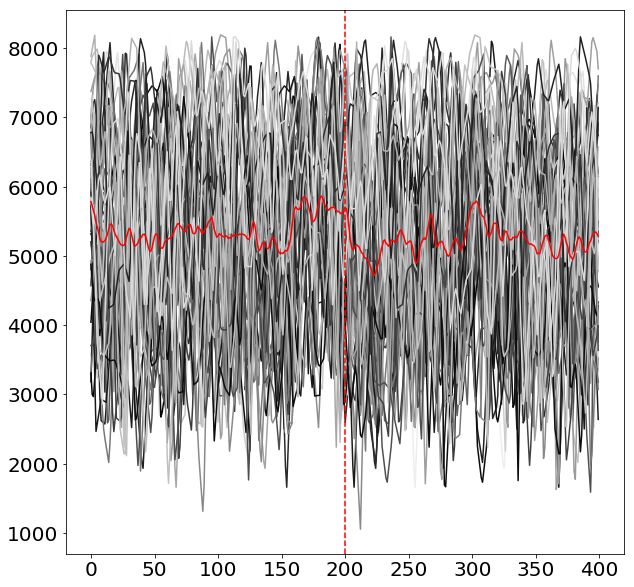

In [110]:
plt.figure(figsize=(10,10))
for i in range(51):
    plt.plot(temp[i,119,56,:],color=str(np.random.uniform()))
plt.plot(np.mean(temp,axis=0)[119,56,:],color='r')
plt.axvline(200,linestyle='--',color='r')

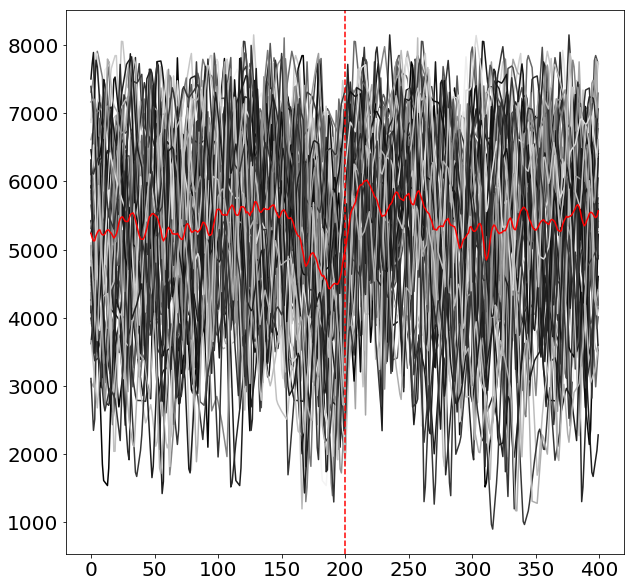

In [96]:
plt.figure(figsize=(10,10))
for i in range(51):
    plt.plot(temp[i,120,57,:],color=str(np.random.uniform()))
plt.plot(np.mean(temp,axis=0)[120,57,:],color='r')
plt.axvline(200,linestyle='--',color='r')

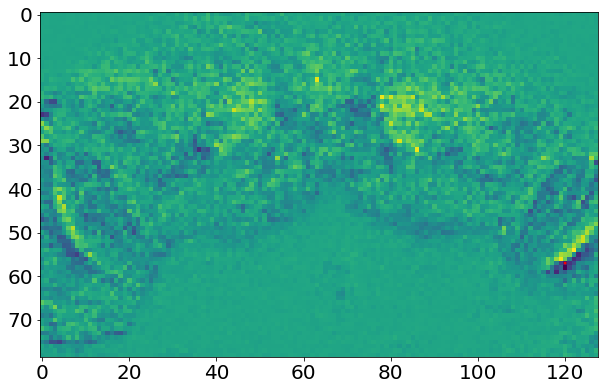

In [131]:
#ax = plt.figure(figsize=(10,10))
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(final2.T)

circle = plt.Circle((120, 57), .2, color='r', clip_on=False)
ax.add_artist(circle)
#fig.colorbar(final2,ax)

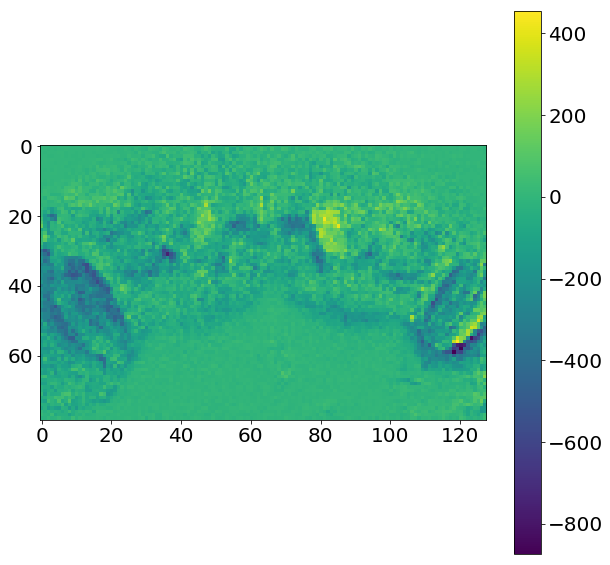

In [136]:
before_avg = np.mean(temp[:,:,:,150:200],axis=-1)
after_avg = np.mean(temp[:,:,:,200:250],axis=-1)
out = before_avg - after_avg
final = np.mean(out,axis=0)

plt.figure(figsize=(10,10))
plt.imshow(final.T)
plt.colorbar()

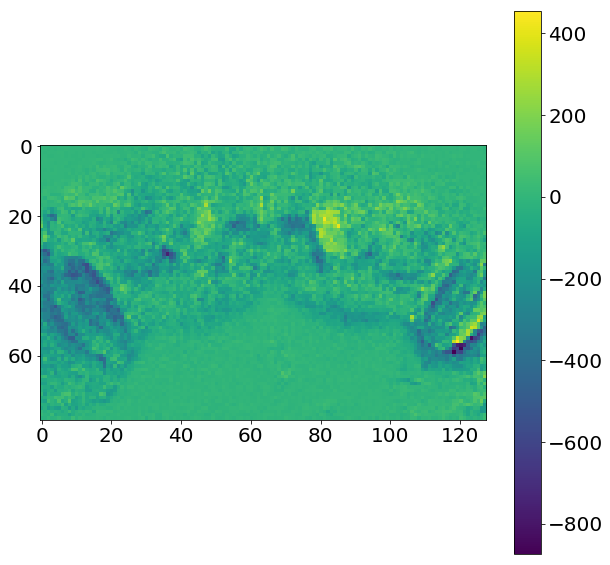

In [135]:
final2 = np.mean(temp, axis=0)
final2 = np.mean(final2[:,:,150:200],axis=-1) - np.mean(final2[:,:,200:250],axis=-1)

plt.figure(figsize=(10,10))
plt.imshow(final2.T)
plt.colorbar()

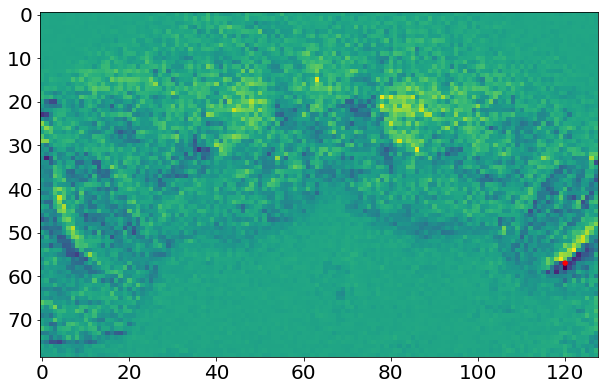

In [109]:
#ax = plt.figure(figsize=(10,10))
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(final.T)

circle = plt.Circle((120, 57), .5, color='r', clip_on=False)
ax.add_artist(circle)

# Dope, lets run through each slice

In [152]:
data.shape[2]

53

In [153]:
#slice_num = 11
slice_values = []
for slice_num in range(data.shape[2]):
    print(slice_num)
    xnew = np.arange(0,expt_len,100) #first trying 100ms instead of 10ms for memory
    out = interp1d(timestamps[:,slice_num], data[:,:,slice_num,:], axis=-1, bounds_error = False)
    slice_test = out(xnew)

    before = 1000 #in ms
    after = 1000 # in ms
    bout_triggered_slice = [slice_test[:,:,
                                       int((bout['start']-before)/10): \
                                       int((bout['start']+after)/10)] for bout in bouts][1:-1]

    # quick and dirty scalarization
    temp = np.asarray(bout_triggered_slice)
    before_avg = np.mean(temp[:,:,:,:100],axis=-1)
    after_avg = np.mean(temp[:,:,:,100:],axis=-1)
    out = before_avg - after_avg
    slice_values.append(np.mean(out,axis=0))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52


In [154]:
slice_values = np.asarray(slice_values)
slice_values_to_save = np.moveaxis(slice_values,0,-1)
slice_values_to_save = ants.from_numpy(slice_values_to_save)
file = os.path.join(root_directory,'fly_21','func_0','20200115_analysis','forward_trigger.nii')
ants.image_write(slice_values_to_save,file)

In [ ]:
before = 3000 #in ms
after = 3000 # in ms

before = int(before/10) # now everything is in units of 10ms
after = int(after/10)
bins = bbb.create_bins(10,before*10,after*10)[:-1]

plt.figure(figsize=(20,10))
x=bins
plt.subplot(131)
for i,bout in enumerate(bouts):
    y=fictrac_interp[bout['start']-before:bout['start']+after]
    try:
        plt.plot(x,y,color=str(np.random.uniform()))
    except:
        print('{} Failed'.format(i))
all_bouts = [fictrac_interp[bout['start']-before:bout['start']+after] for bout in bouts][1:-1]
all_bouts = np.asarray(all_bouts)
avg_bout = np.mean(all_bouts,axis=0)
plt.plot(x,avg_bout,color='xkcd:aqua blue',linewidth=4,marker='x')
plt.axvline(0,linestyle='--',color='r')
plt.xlabel('ms')
#plt.xlim(-300,300)

# xnew = np.arange(0,expt_len,resolution)
# out = interp1d(timestamps[:,25], PB_R_signal, bounds_error = False)
# PB_R_signal_highres = out(xnew)
# out = interp1d(timestamps[:,25], PB_L_signal, bounds_error = False)
# PB_L_signal_highres = out(xnew)

# bout_triggered_PB_R = [PB_R_signal_highres[bout['start']-before:bout['start']+after] for bout in bouts][1:-1]
# #bout_triggered_PB_R_normalized=bout_triggered_PB_R
# bout_triggered_PB_R_normalized = [(bout-np.mean(bout[:200]))/np.mean(bout[:200]) for bout in bout_triggered_PB_R]
# avg_PB_R = np.mean(bout_triggered_PB_R_normalized,axis=0)

# bout_triggered_PB_L = [PB_L_signal_highres[bout['start']-before:bout['start']+after] for bout in bouts][1:-1]
# #bout_triggered_PB_L=bout_triggered_PB_L_normalized
# bout_triggered_PB_L_normalized = [(bout-np.mean(bout[:200]))/np.mean(bout[:200]) for bout in bout_triggered_PB_L]
# avg_PB_L = np.mean(bout_triggered_PB_L_normalized,axis=0)

# plt.subplot(132)
# for i in range(len(PB_R_signal)):
#     try:
#         plt.plot(bins,bout_triggered_PB_R_normalized[i],color=str(np.random.uniform()))
#     except:
#         pass
# plt.plot(x,avg_PB_R,color='xkcd:seafoam green',linewidth=4,marker='x')
# plt.axvline(0,linestyle='--',color='r')
# plt.xlabel('ms')
# #plt.xlim(-300,300)

# plt.subplot(133)
# plt.plot(x,avg_bout,color='xkcd:aqua blue',linewidth=4,marker='x')
# plt.plot(x,avg_PB_R,color='xkcd:seafoam green',linewidth=4,marker='x')
# plt.plot(x,avg_PB_L,color='xkcd:pastel purple',linewidth=4,marker='x')

# plt.axvline(0,linestyle='--',color='r')
# plt.xlabel('ms')
# #plt.xlim(-300,300)
# #plt.ylim(-.03,0.20)

# save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
# timestr = time.strftime("%Y%m%d-%H%M%S")
# fname = os.path.join(save_path, timestr + '.png')
# #plt.savefig(fname,dpi=300,bbox_inches='tight')